In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import inspect
import os
import sys
import time

onp.random.seed(3452453)

In [2]:
from bnpmodeling_runjingdev import result_loading_utils

from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_optimization_lib as reg_optim_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
import regression_plotting_utils


# Load data

In [26]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, gamma, gamma_info, regressors_transformed = \
    genomics_data_utils.load_and_tranform_data(bnp_data_repo, cov_lb=0.5)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [27]:
n_genes = genome_data.shape[0]
reg_dim = gamma.shape[1]

### Plot data and predictions 

In red are predictions by the transformed regression coefficients

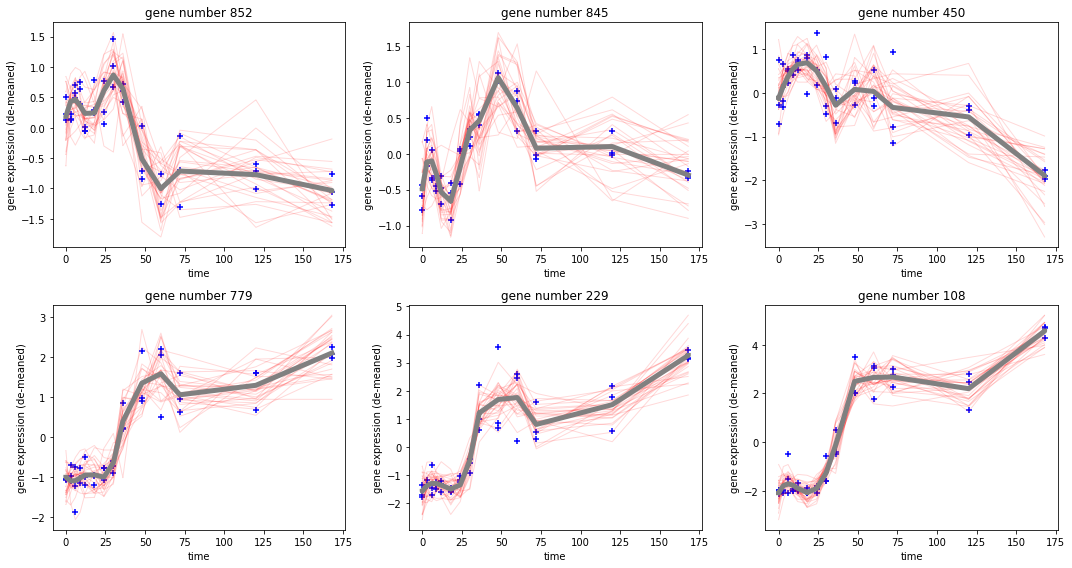

In [28]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):

    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    regression_plotting_utils.plot_data(timepoints, genome_data[n], this_plot, demean = True)
    regression_plotting_utils.plot_prediction_line_and_sample(timepoints, 
                                                              regressors_transformed, 
                                                              gamma[n],
                                                              gamma_info[n],
                                                              this_plot)
    
    this_plot.set_title('gene number {}'.format(n))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')


f.tight_layout()


### The gammas are what we will cluster

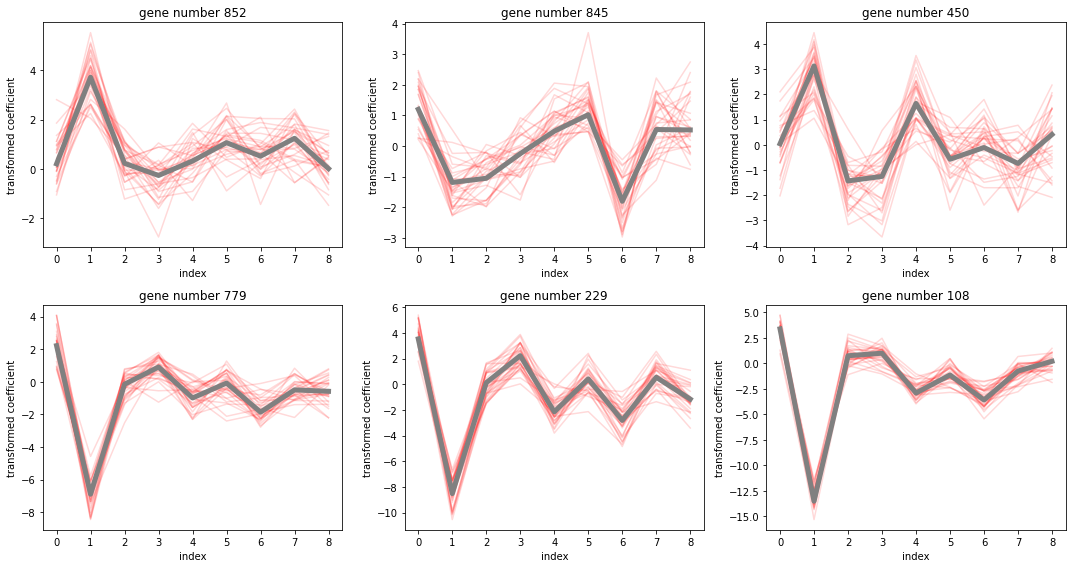

In [29]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_gamma_draw = onp.random.multivariate_normal(
            gamma[n, :], \
             np.linalg.inv(gamma_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_gamma_draw, 
                                                color = 'red', alpha = 0.15);
        
    this_plot.plot(gamma[n, :], color = 'grey', linewidth = 5);

f.tight_layout()


In [30]:
from sklearn.decomposition import PCA

In [31]:
pca_fit = PCA()
pca_fit.fit(gamma)
pc_iris_obs = pca_fit.transform(gamma)


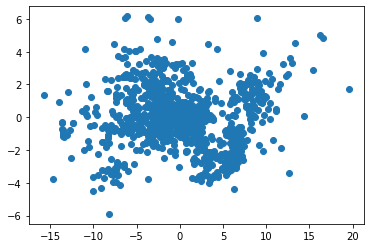

In [32]:
plt.scatter(pc_iris_obs[:, 0], 
         pc_iris_obs[:, 1])

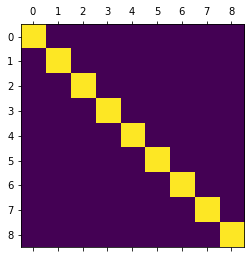

In [33]:
plt.matshow(gamma_info[1])

(array([  4.,  30.,  54.,  62.,  89.,  97., 153., 194., 223.,  94.]),
 array([0.29890725, 0.46310732, 0.62730739, 0.79150745, 0.95570752,
        1.11990759, 1.28410766, 1.44830773, 1.61250779, 1.77670786,
        1.94090793]),
 <BarContainer object of 10 artists>)

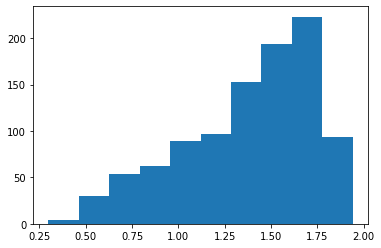

In [34]:
plt.hist(gamma_info[:, 0, 0])

In [35]:
lines = inspect.getsource(regression_mixture_lib.get_e_log_prior)
print(lines)

def get_e_log_prior(stick_means, stick_infos, 
                    centroids,
                    prior_params_dict,
                    gh_loc, gh_weights):
    
    # get expected prior term

    # dp prior
    alpha = prior_params_dict['dp_prior_alpha']

    dp_prior = \
        modeling_lib.get_e_logitnorm_dp_prior(stick_means, stick_infos,
                                              alpha, gh_loc, gh_weights)

    # centroid prior
    prior_mean = prior_params_dict['prior_centroid_mean']
    prior_info = prior_params_dict['prior_centroid_info']

    e_centroid_prior = sp.stats.norm.logpdf(centroids, 
                                            loc = prior_mean, 
                                            scale = 1 / np.sqrt(prior_info)).sum()

    return e_centroid_prior + dp_prior



# Prior parameters

In [36]:
prior_params_dict, vb_params_paragami = regression_mixture_lib.get_default_prior_params(reg_dim)

# VB parameters

In [37]:
k_approx = 50
vb_params_dict, vb_params_paragami = regression_mixture_lib.get_vb_params_paragami_object(reg_dim, k_approx)

In [38]:
vb_params_dict['centroids'].shape

(50, 9)

### Gauss hermite 

In [39]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

# Optimize

In [40]:
vb_params_dict = reg_optim_lib.set_params_w_kmeans(gamma, gamma_info, vb_params_dict, vb_params_paragami, 
                                                   prior_params_dict['dp_prior_alpha'], gh_loc, gh_weights)

running k-means ... 


In [41]:
vb_opt_dict, vb_opt, ez_opt, out, optim_time = \
    reg_optim_lib.optimize_regression_mixture(gamma,
                                              gamma_info, 
                                              vb_params_dict,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights, 
                                              run_newton=True)

compiling objective and derivatives ... 
done. Compile time: 8.679sec
Running L-BFGS-B ...
L-BFGS-B time: 3.420sec
Running trust-ncg ... 
Newton time: 5.333sec
Optimization terminated successfully.
done. 


In [42]:
out.fun

array(-28521.81305414)

# Check out fit

In [43]:
def get_e_num_obs_per_cluster(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_z_from_vb_dict(gamma, gamma_info, vb_params_dict,
                                                             gh_loc, gh_weights)
    
    return ez.sum(0)

In [44]:
def get_mixture_weights(vb_params_free): 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)

In [45]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt)
mixture_weights = get_mixture_weights(vb_opt)

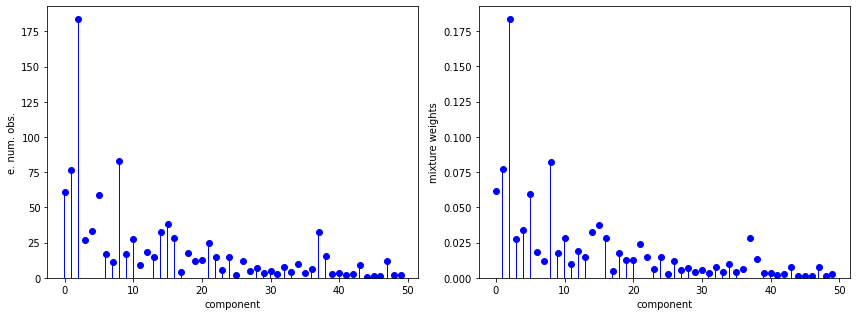

In [46]:
# plot mixture weights and allocations

fig, axarr = plt.subplots(1, 2, figsize = (12, 4.5))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [47]:
len(np.unique(ez_opt.argmax(1)))

46

In [48]:
from bnpmodeling_runjingdev import exponential_families as ef

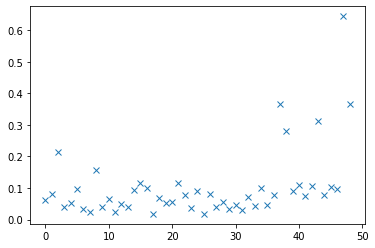

In [49]:
stick_means = ef.get_e_logitnormal(vb_opt_dict['stick_params']['stick_means'],
                              vb_opt_dict['stick_params']['stick_infos'],
                              gh_loc, gh_weights)

plt.plot(stick_means, 'x')

# Plot top centroids

In [50]:
top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)

In [51]:
centroids = vb_opt_dict['centroids']

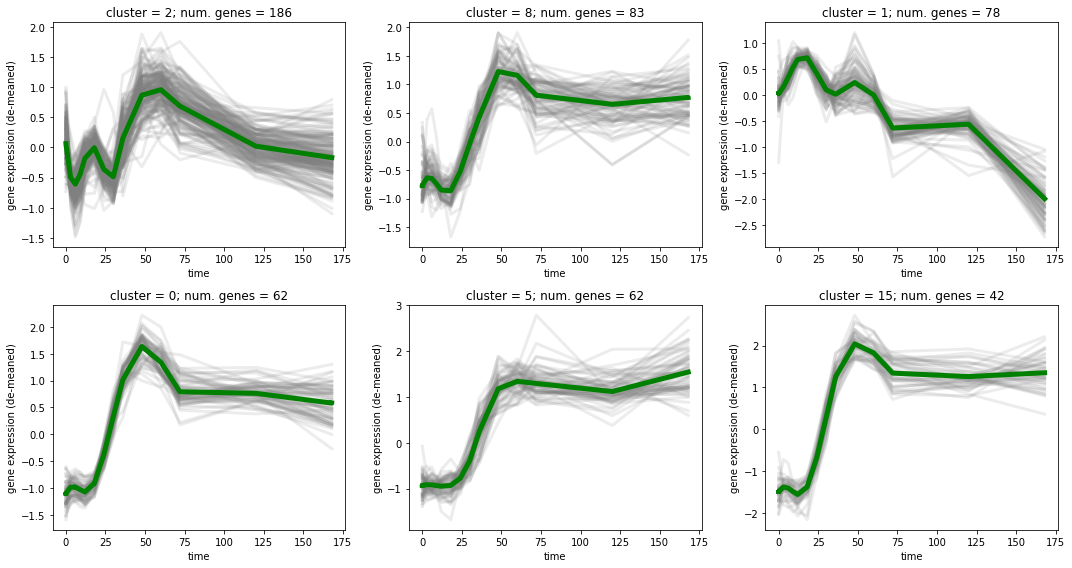

In [52]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(ez_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')

    # Plot genes in this cluster
    for n in which_genes: 
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors_transformed, 
                                                       gamma[n], 
                                                       ax = this_plot, 
                                                       alpha = 0.15, 
                                                       color = 'grey')
        
    # plot centroid
    regression_plotting_utils.plot_prediction_line(timepoints, 
                                                   regressors_transformed, 
                                                   centroids[which_cluster], 
                                                   ax = this_plot, 
                                                   linewidth = 5, 
                                                   color = 'green')
    


f.tight_layout()


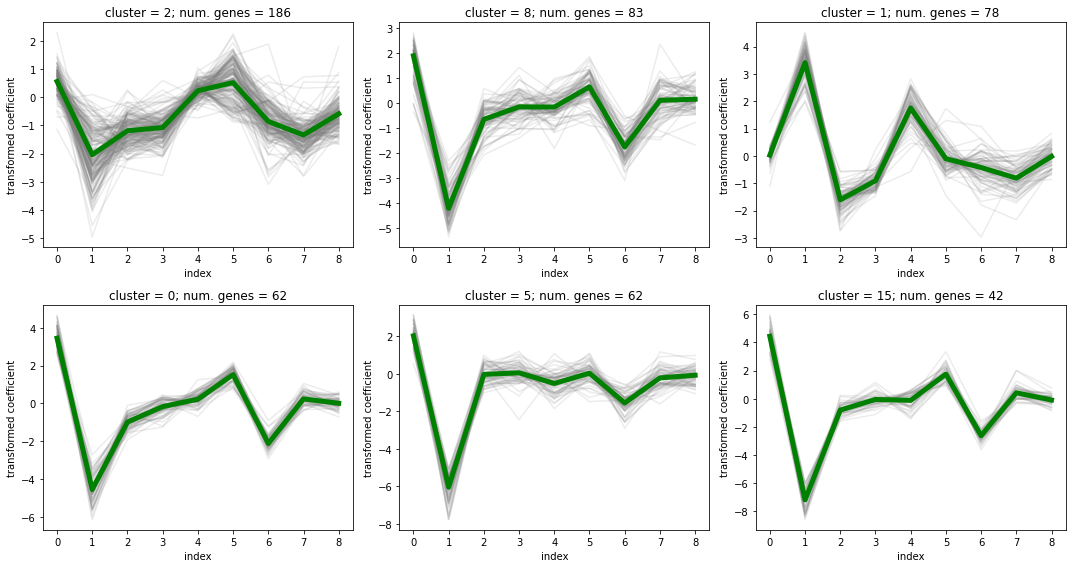

In [53]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(ez_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('index')
    this_plot.set_ylabel('transformed coefficient')
        
    # draw fitted coefficient
    for n in which_genes:
        this_plot.plot(gamma[n, :], alpha = 0.15, color = 'grey')
    
    # draw centroids
    this_plot.plot(centroids[which_cluster, :], linewidth = 5, color = 'green')
    
f.tight_layout()


# Plot a couple genes

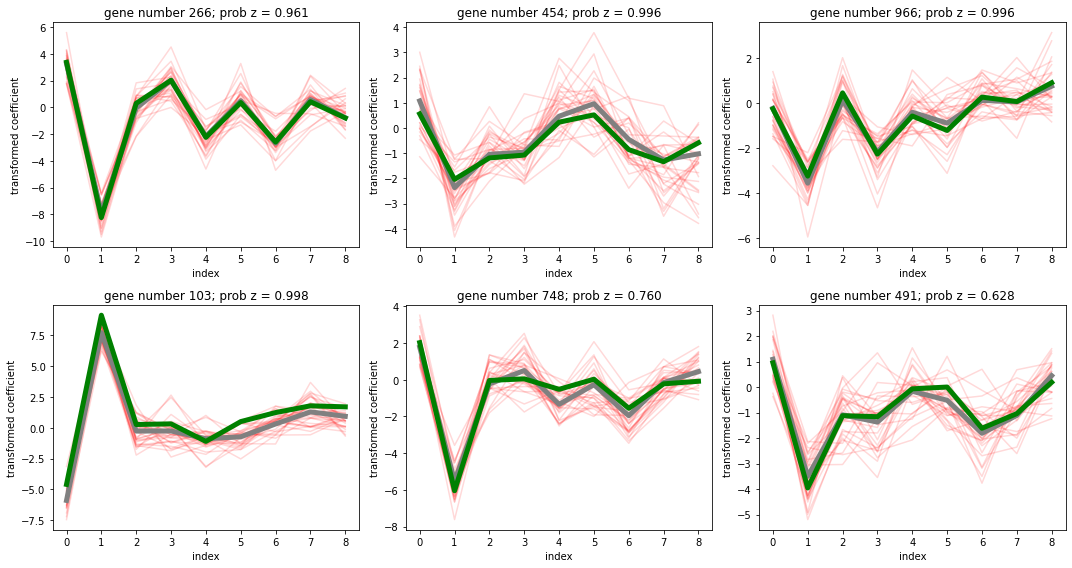

In [54]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):
    n = gene_indx[i]
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number ' + str(n) + \
                        '; prob z = {:.03f}'.format(ez_opt[n].max()))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_gamma_draw = onp.random.multivariate_normal(
            gamma[n, :], \
             np.linalg.inv(gamma_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_gamma_draw, 
                                                color = 'red', alpha = 0.15);
    # plot mean    
    this_plot.plot(gamma[n, :], color = 'grey', linewidth = 5);
    
    # plot centroid 
    which_cluster = np.argmax(ez_opt[n])
    this_plot.plot(centroids[which_cluster, :], linewidth = 5, color = 'green')
    
f.tight_layout()


In [55]:
(ez_opt.argmax(1) == 29).sum()

DeviceArray(4, dtype=int64)

In [56]:
centroids = vb_opt_dict['centroids']
stick_means = vb_opt_dict['stick_params']['stick_means']
stick_infos = vb_opt_dict['stick_params']['stick_infos']

loglik_obs_by_nk = regression_mixture_lib.get_loglik_obs_by_nk(gamma, gamma_info, centroids) 

In [57]:
loglik_obs_by_nk[1]

DeviceArray([  82.39709034,  -58.98368734,   37.55626927,  130.58844629,
             -134.95894488,   97.51813805,  118.44268939,   76.32940613,
               75.92775034,  160.11574743,  -28.45319113, -230.62367239,
               48.81662925,  125.71022872,    3.87502317,  112.99945404,
               83.62233452,   82.09701365,  -81.06778859,  -19.73876692,
               15.14961456,   95.83439851,    8.18175748,  112.62040213,
              -54.7115114 ,  144.79148489,  157.31243734, -165.32664622,
               46.53013272,   85.92640608,  124.03916966,  176.72647553,
              138.4785289 ,  -80.9736863 ,   53.75320615,   34.95317388,
               99.93550955, -106.63340292,  117.04421547,  -56.84988035,
               99.3747595 ,    3.88644376,  116.89949101,   71.42235072,
               28.57239315,   90.88832087,   61.92175891,  136.07245207,
               -6.8794584 , -391.97243854], dtype=float64)

In [58]:
gamma_info

array([[[ 8.89142795e-01,  3.95657225e-16, -3.84000079e-17, ...,
         -1.14171452e-16,  3.17571494e-16,  3.38892927e-17],
        [ 5.67085831e-16,  8.89142795e-01,  1.09714308e-17, ...,
          1.04228593e-16,  5.96571552e-17,  1.77522894e-15],
        [-3.36000069e-17,  3.29142925e-17,  8.89142795e-01, ...,
         -2.73188628e-15, -1.42628601e-16,  5.60571544e-16],
        ...,
        [-2.36228620e-16,  8.22857313e-17, -2.73051485e-15, ...,
          8.89142795e-01,  5.72057261e-16,  5.84014406e-16],
        [ 9.52285911e-17,  3.42857214e-17, -1.38171457e-16, ...,
          5.93228694e-16,  8.89142795e-01, -6.29357273e-17],
        [-1.92273254e-16,  1.71685750e-15,  5.65714403e-16, ...,
          9.10607331e-16, -1.44412530e-16,  8.89142795e-01]],

       [[ 9.24701324e-01,  3.70086945e-16, -3.18912597e-17, ...,
         -1.09394438e-16,  2.13411860e-16,  5.09889327e-17],
        [ 3.19654255e-16,  9.24701324e-01,  7.11990915e-17, ...,
          1.72064471e-16,  8.38072640e

In [59]:
ez_opt[0]

DeviceArray([1.80625405e-027, 1.52578127e-086, 6.71664307e-053,
             6.16905762e-018, 4.58637538e-117, 5.82919918e-032,
             4.83601334e-002, 1.59031378e-039, 5.45191815e-036,
             9.51638438e-001, 2.17805605e-075, 7.56580574e-158,
             2.05098956e-057, 4.03089927e-009, 1.43943705e-064,
             3.27895264e-016, 8.42742290e-041, 2.31435937e-037,
             9.45185242e-098, 1.71096967e-069, 1.44908318e-061,
             1.02494018e-033, 5.91881222e-065, 1.56858141e-036,
             3.46371941e-085, 3.10912662e-025, 2.34894923e-009,
             5.73123799e-124, 8.87982014e-038, 2.33427246e-030,
             5.54333781e-027, 9.20701141e-022, 1.12057566e-025,
             2.32583938e-098, 9.99420632e-044, 4.37164037e-059,
             1.39902624e-012, 3.72205943e-104, 1.05175247e-023,
             1.70571802e-084, 1.25465914e-021, 7.95583467e-066,
             6.88457542e-023, 4.75877564e-044, 1.17915493e-052,
             2.92583123e-033, 2.59298878

In [60]:
regression_mixture_lib.modeling_lib.get_e_log_cluster_probabilities(stick_means, stick_infos, gh_loc, gh_weights)

DeviceArray([-2.79425559, -2.56342489, -1.69828465, -3.59942595,
             -3.39982609, -2.83004604, -4.04589801, -4.44029903,
             -2.50337247, -4.07335366, -3.58690993, -4.68391167,
             -3.99010126, -4.22904299, -3.43099859, -3.29066521,
             -3.57898881, -5.48491587, -4.06816884, -4.4282506 ,
             -4.40547313, -3.75116782, -4.25555781, -5.14975974,
             -4.24551308, -6.0520929 , -4.455125  , -5.28577064,
             -4.98334098, -5.62930868, -5.29408759, -5.77023974,
             -4.92201839, -5.55090112, -4.69646503, -5.65834993,
             -5.13131915, -3.59400306, -4.33159992, -5.90453598,
             -5.76842899, -6.32313092, -6.03927605, -4.96923819,
             -6.95223782, -6.71884331, -6.9203375 , -4.9124561 ,
             -6.65009546, -6.03416984], dtype=float64)

In [19]:
# regr_mixture_obj = reg_optim_lib.RegressionMixture_objective(gamma, gamma_info, vb_params_paragami, prior_params_dict, gh_loc, gh_weights)